# Clustering The World on COVID-19 Cases

This project attempts to cluster 191 countries according to the pattern of COVID-19 cases in the past 28 days.

## 1. Data Preparation

### Import Libraries

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.io as pio

from datetime import date, datetime, timedelta

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

pio.renderers.default = 'notebook_connected'

Set number of days for the study.

In [2]:
ndays = 28
dateformat = '%Y-%m-%d'

### Load Data

In [3]:
dataset_url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df = pd.read_csv(dataset_url)
df

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
57868,2020-11-15,Zimbabwe,8829,8096,257
57869,2020-11-16,Zimbabwe,8897,8116,257
57870,2020-11-17,Zimbabwe,8945,8164,260
57871,2020-11-18,Zimbabwe,8981,8184,261


### Data Wrangling

In [4]:
df = df.assign(Cases = df['Confirmed'].diff())
df.dropna(inplace = True)
df

,Date,Country,Confirmed,Recovered,Deaths,Cases
1,2020-01-23,Afghanistan,0,0,0,0.0
2,2020-01-24,Afghanistan,0,0,0,0.0
3,2020-01-25,Afghanistan,0,0,0,0.0
4,2020-01-26,Afghanistan,0,0,0,0.0
5,2020-01-27,Afghanistan,0,0,0,0.0
...,...,...,...,...,...,...
57868,2020-11-15,Zimbabwe,8829,8096,257,43.0
57869,2020-11-16,Zimbabwe,8897,8116,257,68.0
57870,2020-11-17,Zimbabwe,8945,8164,260,48.0
57871,2020-11-18,Zimbabwe,8981,8184,261,36.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57872 entries, 1 to 57872
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       57872 non-null  object 
 1   Country    57872 non-null  object 
 2   Confirmed  57872 non-null  int64  
 3   Recovered  57872 non-null  int64  
 4   Deaths     57872 non-null  int64  
 5   Cases      57872 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.1+ MB


In [6]:
df['Cases'] = df['Cases'].astype(int)
df

,Date,Country,Confirmed,Recovered,Deaths,Cases
1,2020-01-23,Afghanistan,0,0,0,0
2,2020-01-24,Afghanistan,0,0,0,0
3,2020-01-25,Afghanistan,0,0,0,0
4,2020-01-26,Afghanistan,0,0,0,0
5,2020-01-27,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
57868,2020-11-15,Zimbabwe,8829,8096,257,43
57869,2020-11-16,Zimbabwe,8897,8116,257,68
57870,2020-11-17,Zimbabwe,8945,8164,260,48
57871,2020-11-18,Zimbabwe,8981,8184,261,36


### Calculate Dates

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format = dateformat)
df.dtypes

Date         datetime64[ns]
Country              object
Confirmed             int64
Recovered             int64
Deaths                int64
Cases                 int32
dtype: object

In [8]:
df.drop(['Confirmed', 'Recovered', 'Deaths'], axis = 1, inplace = True)
df

,Date,Country,Cases
1,2020-01-23,Afghanistan,0
2,2020-01-24,Afghanistan,0
3,2020-01-25,Afghanistan,0
4,2020-01-26,Afghanistan,0
5,2020-01-27,Afghanistan,0
...,...,...,...
57868,2020-11-15,Zimbabwe,43
57869,2020-11-16,Zimbabwe,68
57870,2020-11-17,Zimbabwe,48
57871,2020-11-18,Zimbabwe,36


In [9]:
end = df['Date'].max()
end

Timestamp('2020-11-19 00:00:00')

In [10]:
start = end - timedelta(days = (ndays - 1))
start

Timestamp('2020-10-23 00:00:00')

### Create New Table

In [11]:
df_period = df[df['Date'] >= start]
df_period

,Date,Country,Cases
275,2020-10-23,Afghanistan,61
276,2020-10-24,Afghanistan,81
277,2020-10-25,Afghanistan,65
278,2020-10-26,Afghanistan,104
279,2020-10-27,Afghanistan,95
...,...,...,...
57868,2020-11-15,Zimbabwe,43
57869,2020-11-16,Zimbabwe,68
57870,2020-11-17,Zimbabwe,48
57871,2020-11-18,Zimbabwe,36


In [12]:
countries = df_period['Country'].unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [13]:
df_grouped = df_period.groupby('Country')
df_grouped

In [14]:
sums = df_grouped['Cases'].sum()
sums

Country
Afghanistan            3602
Albania               12373
Algeria               16295
Andorra                2255
Angola                 5552
                      ...  
West Bank and Gaza    18162
Western Sahara            0
Yemen                    29
Zambia                 1315
Zimbabwe                804
Name: Cases, Length: 191, dtype: int32

In [15]:
means = df_grouped['Cases'].mean()
means

Country
Afghanistan           128.642857
Albania               441.892857
Algeria               581.964286
Andorra                80.535714
Angola                198.285714
                         ...    
West Bank and Gaza    648.642857
Western Sahara          0.000000
Yemen                   1.035714
Zambia                 46.964286
Zimbabwe               28.714286
Name: Cases, Length: 191, dtype: float64

In [16]:
stds = df_grouped['Cases'].std()
stds

Country
Afghanistan            73.388976
Albania               148.006091
Algeria               275.286313
Andorra                67.569707
Angola                 73.883721
                         ...    
West Bank and Gaza    213.130149
Western Sahara          0.000000
Yemen                   1.574852
Zambia                 27.523030
Zimbabwe               19.240885
Name: Cases, Length: 191, dtype: float64

In [17]:
maxes = df_grouped['Cases'].max()
maxes

Country
Afghanistan            377
Albania                786
Algeria               1038
Andorra                287
Angola                 355
                      ... 
West Bank and Gaza    1251
Western Sahara           0
Yemen                    6
Zambia                 118
Zimbabwe                69
Name: Cases, Length: 191, dtype: int32

In [18]:
mins = df_grouped['Cases'].min()
mins

Country
Afghanistan            40
Albania               241
Algeria               250
Andorra                 0
Angola                 77
                     ... 
West Bank and Gaza    410
Western Sahara          0
Yemen                   0
Zambia                  0
Zimbabwe                5
Name: Cases, Length: 191, dtype: int32

In [19]:
medians = df_grouped['Cases'].median()
medians

Country
Afghanistan           108.5
Albania               415.5
Algeria               606.0
Andorra                65.5
Angola                200.0
                      ...  
West Bank and Gaza    603.5
Western Sahara          0.0
Yemen                   0.0
Zambia                 42.5
Zimbabwe               27.0
Name: Cases, Length: 191, dtype: float64

In [20]:
df_countries = pd.DataFrame(
    {
        'Country': countries,
        'Sum': sums,
        'Mean': means,
        'Std': stds,
        'Max': maxes,
        'Min': mins,
        'Median': medians
    }
)

df_countries

,Country,Sum,Mean,Std,Max,Min,Median
Country,,,,,,,
Afghanistan,Afghanistan,3602,128.642857,73.388976,377,40,108.5
Albania,Albania,12373,441.892857,148.006091,786,241,415.5
Algeria,Algeria,16295,581.964286,275.286313,1038,250,606.0
Andorra,Andorra,2255,80.535714,67.569707,287,0,65.5
Angola,Angola,5552,198.285714,73.883721,355,77,200.0
...,...,...,...,...,...,...,...
West Bank and Gaza,West Bank and Gaza,18162,648.642857,213.130149,1251,410,603.5
Western Sahara,Western Sahara,0,0.000000,0.000000,0,0,0.0
Yemen,Yemen,29,1.035714,1.574852,6,0,0.0


In [21]:
df_countries.reset_index(drop = True, inplace = True)
df_countries

,Country,Sum,Mean,Std,Max,Min,Median
0,Afghanistan,3602,128.642857,73.388976,377,40,108.5
1,Albania,12373,441.892857,148.006091,786,241,415.5
2,Algeria,16295,581.964286,275.286313,1038,250,606.0
3,Andorra,2255,80.535714,67.569707,287,0,65.5
4,Angola,5552,198.285714,73.883721,355,77,200.0
...,...,...,...,...,...,...,...
186,West Bank and Gaza,18162,648.642857,213.130149,1251,410,603.5
187,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,Yemen,29,1.035714,1.574852,6,0,0.0
189,Zambia,1315,46.964286,27.523030,118,0,42.5


### Explore Data

In [22]:
df_countries.isnull().sum()

Country    0
Sum        0
Mean       0
Std        0
Max        0
Min        0
Median     0
dtype: int64

In [23]:
df_countries[df_countries['Country'] == 'US']

,Country,Sum,Mean,Std,Max,Min,Median
176,US,3314325,118368.75,37324.840245,187833,61760,122231.5


In [24]:
df_countries[df_countries['Country'] == 'India']

,Country,Sum,Mean,Std,Max,Min,Median
79,India,1243053,44394.75,5760.677652,53370,29163,45625.0


In [25]:
df_countries[df_countries['Country'] == 'Malaysia']

,Country,Sum,Mean,Std,Max,Min,Median
107,Malaysia,27876,995.571429,249.742598,1755,649,964.5


## 2. Data Visualization

In [65]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Sum')
fig.update_layout(title_text = f'COVID-19 - Total Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show(renderer = 'notebook_connected')

In [27]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Mean')
fig.update_layout(title_text = f'COVID-19 - Daily Average Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [28]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Std')
fig.update_layout(title_text = f'COVID-19 - Standard Deviation of Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [29]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Max')
fig.update_layout(title_text = f'COVID-19 - Highest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [30]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Min')
fig.update_layout(title_text = f'COVID-19 - Lowest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [31]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Median')
fig.update_layout(title_text = f'COVID-19 - Median Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [32]:
df_countries.corr()

,Sum,Mean,Std,Max,Min,Median
Sum,1.000000,1.000000,0.891452,0.956053,0.924207,0.999125
Mean,1.000000,1.000000,0.891452,0.956053,0.924207,0.999125
Std,0.891452,0.891452,1.000000,0.980587,0.663455,0.879485
Max,0.956053,0.956053,0.980587,1.000000,0.783405,0.946807
Min,0.924207,0.924207,0.663455,0.783405,1.000000,0.932877
Median,0.999125,0.999125,0.879485,0.946807,0.932877,1.000000


## Model Training

In [33]:
Features = df_countries.drop(['Country', 'Sum'], axis = 1).columns
# Features = ['Std', 'Min']
Features

Index(['Mean', 'Std', 'Max', 'Min', 'Median'], dtype='object')

In [34]:
scaled_features = StandardScaler().fit_transform(df_countries[Features])

In [35]:
start = 2
end = 11

sse = []

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

for k in range(start, end):
    print(f'Trying {k} clusters...')
    
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    print(f'SSE: {kmeans.inertia_}')
    
    print()

Trying 2 clusters...
SSE: 394.63612400052114

Trying 3 clusters...
SSE: 145.21427420358867

Trying 4 clusters...
SSE: 117.11854387017866

Trying 5 clusters...
SSE: 58.68848575137319

Trying 6 clusters...
SSE: 53.224371353473686

Trying 7 clusters...
SSE: 51.955053075231845

Trying 8 clusters...
SSE: 47.86152844199185

Trying 9 clusters...
SSE: 47.415093682679036

Trying 10 clusters...
SSE: 47.203949878656246



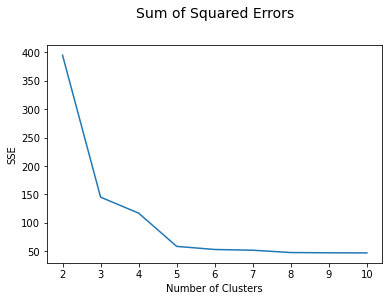

In [36]:
plt.plot(range(start, end), sse)
plt.xticks(range(start, end))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors', y = 1.1, fontsize = 14)
plt.show()

In [37]:
kl = KneeLocator(
   range(start, end), sse, curve="convex", direction="decreasing"
)

print(f'The optimal number of clusters: {kl.elbow}')

The optimal number of clusters: 5


In [38]:
kclusters = kl.elbow

kmeans = KMeans(n_clusters = kclusters, **kmeans_kwargs)
kmeans.fit(scaled_features)

labels = kmeans.labels_ + 1
labels

array([1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 4, 1, 1, 1, 3, 1, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 4, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Explore Clusters

In [39]:
if 'Cluster' in df_countries.columns:
    df_countries.drop('Cluster', axis = 1, inplace = True)
    
df_countries.insert(0, 'Cluster', labels)
df_countries

,Cluster,Country,Sum,Mean,Std,Max,Min,Median
0,1,Afghanistan,3602,128.642857,73.388976,377,40,108.5
1,1,Albania,12373,441.892857,148.006091,786,241,415.5
2,1,Algeria,16295,581.964286,275.286313,1038,250,606.0
3,1,Andorra,2255,80.535714,67.569707,287,0,65.5
4,1,Angola,5552,198.285714,73.883721,355,77,200.0
...,...,...,...,...,...,...,...,...
186,1,West Bank and Gaza,18162,648.642857,213.130149,1251,410,603.5
187,1,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,1,Yemen,29,1.035714,1.574852,6,0,0.0
189,1,Zambia,1315,46.964286,27.523030,118,0,42.5


In [40]:
df_countries

,Cluster,Country,Sum,Mean,Std,Max,Min,Median
0,1,Afghanistan,3602,128.642857,73.388976,377,40,108.5
1,1,Albania,12373,441.892857,148.006091,786,241,415.5
2,1,Algeria,16295,581.964286,275.286313,1038,250,606.0
3,1,Andorra,2255,80.535714,67.569707,287,0,65.5
4,1,Angola,5552,198.285714,73.883721,355,77,200.0
...,...,...,...,...,...,...,...,...
186,1,West Bank and Gaza,18162,648.642857,213.130149,1251,410,603.5
187,1,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,1,Yemen,29,1.035714,1.574852,6,0,0.0
189,1,Zambia,1315,46.964286,27.523030,118,0,42.5


### Visualize Clusters

In [41]:
df_plot = pd.DataFrame(df_countries['Cluster'].value_counts(sort = False))
df_plot.index.name = 'Cluster'
df_plot.columns = ['Count']
df_plot

,Count
Cluster,
1,167
2,1
3,5
4,15
5,3


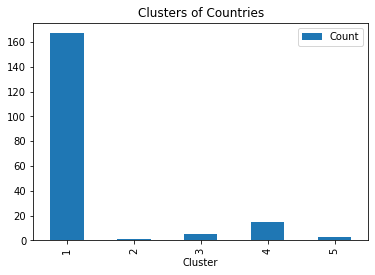

In [42]:
df_plot.plot.bar(title = 'Clusters of Countries')

Learn the characteristics of each cluster.

In [43]:
df_clusters = df_countries.groupby('Cluster')
df_clusters

In [44]:
df_clusters['Sum'].mean()

Cluster
1    1.459271e+04
2    3.314325e+06
3    7.712998e+05
4    2.221967e+05
5    7.561783e+05
Name: Sum, dtype: float64

In [45]:
df_clusters['Mean'].mean()

Cluster
1       521.168306
2    118368.750000
3     27546.421429
4      7935.595238
5     27006.369048
Name: Mean, dtype: float64

In [46]:
df_clusters['Std'].mean()

Cluster
1      188.962953
2    37324.840245
3     4493.178687
4     3144.526928
5    19216.005463
Name: Std, dtype: float64

In [47]:
df_clusters['Max'].mean()

Cluster
1       945.514970
2    187833.000000
3     35800.200000
4     14518.000000
5     76362.666667
Name: Max, dtype: float64

In [48]:
df_clusters['Min'].mean()

Cluster
1      212.395210
2    61760.000000
3    18252.800000
4     2978.066667
5        8.333333
Name: Min, dtype: float64

In [49]:
df_clusters['Median'].mean()

Cluster
1       520.661677
2    122231.500000
3     28242.900000
4      7546.033333
5     26244.000000
Name: Median, dtype: float64

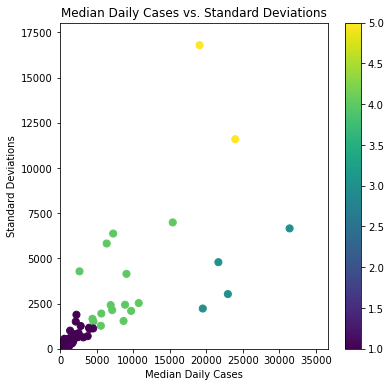

In [50]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)

scatter = ax.scatter(df_countries['Median'], df_countries['Std'], c = df_countries['Cluster'], s = 50)

ax.set_title('Median Daily Cases vs. Standard Deviations')
ax.set_xlabel('Median Daily Cases')
ax.set_ylabel('Standard Deviations')
ax.set_xlim(0, df_countries['Median'].quantile(0.99))
ax.set_ylim(0, df_countries['Std'].quantile(0.99))

plt.colorbar(scatter)

### List Clusters

In [54]:
for i in range(1, kclusters + 1):
    print(df_clusters.get_group(i))

     Cluster             Country    Sum        Mean         Std   Max  Min  \
0          1         Afghanistan   3602  128.642857   73.388976   377   40   
1          1             Albania  12373  441.892857  148.006091   786  241   
2          1             Algeria  16295  581.964286  275.286313  1038  250   
3          1             Andorra   2255   80.535714   67.569707   287    0   
4          1              Angola   5552  198.285714   73.883721   355   77   
..       ...                 ...    ...         ...         ...   ...  ...   
186        1  West Bank and Gaza  18162  648.642857  213.130149  1251  410   
187        1      Western Sahara      0    0.000000    0.000000     0    0   
188        1               Yemen     29    1.035714    1.574852     6    0   
189        1              Zambia   1315   46.964286   27.523030   118    0   
190        1            Zimbabwe    804   28.714286   19.240885    69    5   

     Median  
0     108.5  
1     415.5  
2     606.0  
3      

In [66]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Cluster')
fig.update_layout(title_text = f'Clustering The World into {kclusters} Clusters based on COVID-19 Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

### Save Data

In [52]:
filename = 'countries-' + datetime.now().strftime('%Y%m%d%H%M') + '.csv'
filename

'countries-202011211254.csv'

In [53]:
df_countries.to_csv(filename, index = False)